## Image classifiaction

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import packages

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os

import shutil
from tqdm import tqdm

### Data transformation

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),}


### Import image dataset

In [4]:
data_dir = 'final_project/project_sample'
image_datasets = datasets.ImageFolder(
    data_dir,
    # os.path.join(data_dir, 'project_sample'),
    data_transforms['train']
    )

In [5]:
image_datasets

Dataset ImageFolder
    Number of datapoints: 24940
    Root location: final_project/project_sample
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Split dataset into train and val, and also create `dataloaders`

In [6]:

def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
#     datasets['train'] = Subset(dataset, train_idx[:50])
#     datasets['val'] = Subset(dataset, val_idx[:20])
    return datasets

# print(len(dataset))
image_datasets = train_val_dataset(image_datasets)


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True,
                                              num_workers=6
                                             )
              for x in ['train',
                        'val'
                       ]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train',
                                                     'val'
                                                    ]}
class_names = image_datasets['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Function for `accuracy` and `losses` charts after training

In [7]:
def accuracy_loss_charts(num_epochs, acc_list, loss_list):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(np.arange(1,num_epochs+1), [i for i in acc_list['val']],label="val")
    axes[0].plot(np.arange(1,num_epochs+1), [i for i in acc_list['train']],label="train")

    axes[0].legend()
    axes[0].set_title('Train / val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')

    axes[1].plot(np.arange(1,num_epochs+1), [i for i in loss_list['val']],label="val")
    axes[1].plot(np.arange(1,num_epochs+1), [i for i in loss_list['train']],label="train")

    axes[1].legend()
    axes[1].set_title('Train / val loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

    plt.show()

### Function for `confusion matrix` vizualization

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def heatmap(actual, preds, x_y_label):
    cm = confusion_matrix(actual, preds)

    plt.figure(figsize = (5,5))
    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, fontsize = 10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 10)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(x_y_label)
    ax.yaxis.set_ticklabels(x_y_label)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

### Image classes

In [9]:
dataloaders['train'].dataset.dataset.classes

['ad', 'file', 'handwritten', 'others']

### Function for training

In [11]:
def train_model(model,dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    acc_list = {
        'train': [],
        'val' : []
    }
    loss_list = {
        'train': [],
        'val' : []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            acc_list[phase].append(epoch_acc)
            loss_list[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = preds.tolist()
                best_labels = labels.data.tolist()
        torch.cuda.empty_cache()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    accuracy_loss_charts(num_epochs, acc_list, loss_list)
    heatmap(best_labels, best_preds, dataloaders['train'].dataset.dataset.classes)
    
    return model

### Import `VGG16`, change last layer and set `optimizer` and `loss`

In [12]:
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[-1] = torch.nn.Linear(4096,4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),
                          # lr=0.01
                          )


# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

### Training

Epoch 0/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:06<00:00, 18.33s/it]


train Loss: 1.0994 Acc: 0.5361


100%|███████████████████████████████████████████| 50/50 [05:06<00:00,  6.14s/it]


val Loss: 0.7702 Acc: 0.7123

Epoch 1/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:02<00:00, 18.31s/it]


train Loss: 0.7291 Acc: 0.7372


100%|███████████████████████████████████████████| 50/50 [05:05<00:00,  6.11s/it]


val Loss: 0.7850 Acc: 0.7099

Epoch 2/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:07<00:00, 18.34s/it]


train Loss: 0.5804 Acc: 0.8115


100%|███████████████████████████████████████████| 50/50 [05:04<00:00,  6.10s/it]


val Loss: 0.5320 Acc: 0.8278

Epoch 3/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:25<00:00, 18.43s/it]


train Loss: 0.4936 Acc: 0.8402


100%|███████████████████████████████████████████| 50/50 [05:06<00:00,  6.13s/it]


val Loss: 0.4552 Acc: 0.8557

Epoch 4/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:21<00:00, 18.41s/it]


train Loss: 0.4168 Acc: 0.8680


100%|███████████████████████████████████████████| 50/50 [05:06<00:00,  6.14s/it]


val Loss: 0.4197 Acc: 0.8631

Epoch 5/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:19<00:00, 18.40s/it]


train Loss: 0.3961 Acc: 0.8722


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


val Loss: 0.4145 Acc: 0.8657

Epoch 6/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:27<00:00, 18.44s/it]


train Loss: 0.3893 Acc: 0.8743


100%|███████████████████████████████████████████| 50/50 [05:07<00:00,  6.14s/it]


val Loss: 0.3899 Acc: 0.8729

Epoch 7/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:29<00:00, 18.45s/it]


train Loss: 0.3798 Acc: 0.8796


100%|███████████████████████████████████████████| 50/50 [05:07<00:00,  6.15s/it]


val Loss: 0.3890 Acc: 0.8717

Epoch 8/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:46<00:00, 18.53s/it]


train Loss: 0.3761 Acc: 0.8804


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


val Loss: 0.3872 Acc: 0.8715

Epoch 9/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:31<00:00, 18.46s/it]


train Loss: 0.3647 Acc: 0.8845


100%|███████████████████████████████████████████| 50/50 [05:09<00:00,  6.19s/it]


val Loss: 0.3787 Acc: 0.8767

Epoch 10/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:34<00:00, 18.47s/it]


train Loss: 0.3674 Acc: 0.8813


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


val Loss: 0.3931 Acc: 0.8735

Epoch 11/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:38<00:00, 18.49s/it]


train Loss: 0.3594 Acc: 0.8844


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.17s/it]


val Loss: 0.3900 Acc: 0.8737

Epoch 12/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:37<00:00, 18.49s/it]


train Loss: 0.3642 Acc: 0.8834


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.18s/it]


val Loss: 0.3826 Acc: 0.8723

Epoch 13/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:35<00:00, 18.48s/it]


train Loss: 0.3637 Acc: 0.8838


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


val Loss: 0.3896 Acc: 0.8731

Epoch 14/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:38<00:00, 18.49s/it]


train Loss: 0.3645 Acc: 0.8829


100%|███████████████████████████████████████████| 50/50 [05:09<00:00,  6.19s/it]


val Loss: 0.3852 Acc: 0.8741

Epoch 15/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:41<00:00, 18.51s/it]


train Loss: 0.3652 Acc: 0.8833


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.16s/it]


val Loss: 0.3825 Acc: 0.8737

Epoch 16/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:44<00:00, 18.52s/it]


train Loss: 0.3600 Acc: 0.8834


100%|███████████████████████████████████████████| 50/50 [05:10<00:00,  6.20s/it]


val Loss: 0.3921 Acc: 0.8697

Epoch 17/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:43<00:00, 18.52s/it]


train Loss: 0.3628 Acc: 0.8841


100%|███████████████████████████████████████████| 50/50 [05:08<00:00,  6.17s/it]


val Loss: 0.3739 Acc: 0.8815

Epoch 18/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:43<00:00, 18.52s/it]


train Loss: 0.3650 Acc: 0.8849


100%|███████████████████████████████████████████| 50/50 [05:09<00:00,  6.18s/it]


val Loss: 0.3903 Acc: 0.8741

Epoch 19/19
----------


100%|███████████████████████████████████████| 200/200 [1:01:45<00:00, 18.53s/it]


train Loss: 0.3594 Acc: 0.8870


100%|███████████████████████████████████████████| 50/50 [05:10<00:00,  6.21s/it]


val Loss: 0.3763 Acc: 0.8769

Training complete in 1333m 3s
Best val Acc: 0.881516


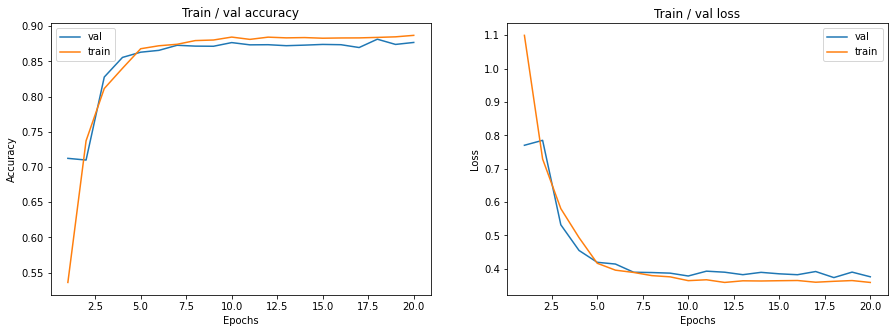

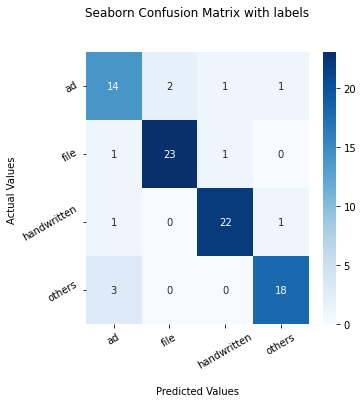

In [14]:
model_ft = train_model(model_ft,dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

### Save model

In [15]:
model_save_name = 'model_vgg_label_4_epoch_20_final.pth'

torch.save(
    model_ft.state_dict(),
    model_save_name
    )

### Thanks